# Bayesian estimation equivalent of the one-sample t-test

This notebook follows nicely on from the Bayesian equivalent of the classical Z-test and provides an example equivalent of a Bayesian one sample t-test. However, the analyis below is conducted on a real dataset and demonstrates for a simple case the realities of fully probabalistic statistical modelling and dealing with uncertainty under the Bayesian framework.


## The classic one sample t-test

Before going any further, a brief review of the one sample t-test is given. The one-sample t-test calculates a t-statistic from calculating the difference between the sample mean and theorised known null hypothesis population mean and then finding the quotient of this difference over the estimated standard error from the sample data.


$$ \large t = \frac{\bar{X}-\mu_0}{\frac{S}{\sqrt{N}}}$$ 

where

$\mu_0 = $ is a theorised constant for the population mean

$\bar{X} = $ sample mean

$N = $ Sample size

$S = $ sample standard deviation

$\frac{S}{\sqrt{N}} = $ estimated standard error


This t statistic is then used to calulate a p-value under a null sampling distribution with a certain degrees of freedom which is determiend by the smaple size ($df = n - 1$). If this p-value is $\leq$ to the 𝛼 level pre-determined before the analysis under the Null hypothesis significance test the resuts is determined to be statistically signicant and the null hypothesis is rejected.

$$ \large H_0:\bar{X} = \mu_0$$
$$ \large H_1:\bar{X}\neq \mu_0$$

# Bayesian inference
<font size = "3"> Following on from that quick description of the classic one sample t-test above its important to keep in mind that Bayesian inference is all derived from the application of Bayes rule 
$$P(\theta \mid y) = \frac{P(y \mid \theta) \, P(\theta)}{P(y)}$$

and as such while the following description of the Bayesian model is an equivalent to the one sample t-test, it is fundamentally different, because it uses fully probabilistic modelling and the inference is not based on sampling distributions.</font>
    
<font size = "1"> For a fuller description see the Practicing Bayesian statistics markdown file within the Github repository.</font>

# Steps of Bayesian data analysis

<font size = "3"> Kruscke (2015) offers a step by step formulation for how to conduct a Bayesian analysis:

1. Identify the relevant data for the question under investigation.

2. Define the descriptive (mathematical) model for the data.

3. Specify the Priors for the model. If scientific research publication is the goal the priors will need to be accepted by a skeptical audience. This should be achievable using prior predictive checks to ascertain if the priors are reasonable.

4. Using Bayes rule estimate the posterior for the parameters of the model using the likelihood and priors. Then use the posterior for conducting your inferences.

5. Conduct model checks. i.e. Posterior predcitive checks.</font> 

<font size = "1">This notebook will follow this approach generally.</font> 

#  Step 1 - Identify the relevant data for the question under investigation

## Study/data description

T## Study/Data Description

The data analysed here were originally produced and analysed by Mehr, S. A., Song, L. A., and Spelke, E. S. (2016) in their study titled *For 5-Month-Old Infants, Melodies Are Social*, published in *Psychological Science, 27*, 486-501. The data, which were downloaded from [OpenStatsLab](https://sites.google.com/view/openstatslab/home), are stored in the same GitHub repository where these notebooks are located.

The research focused on the universal act of parents singing to their children and the impact this act has on focusing the child's attention towards the parent. Mehr et al. (2016) aimed to study the function of singing between mothers and their infants, specifically hypothesising that melodies convey social information to infants.

The researchers argued that social groups share melodies and that different groups have different melodies. These shared melodies might signal to infants that novel individuals who sing these familiar songs belong to the same social group. Therefore, if a novel person sings a familiar melody, it may signal to the infant that the person belongs to the same group.

A total of 32 parent-infant pairs were recruited to test the hypothesis that melodies signal group membership to infants. The methodology involved each infant and mother pair attending an initial visit to the lab, where the mother was taught a new lullaby. The parents were then asked to sing the lullaby to their infant daily for one to two weeks before returning to the lab for the experimental session.

The experimental session involved showing the infants side-by-side videos of two unfamiliar individuals, each on separate screens. As with many infant studies, infant gaze was used as the standard behavioural measure for assessing attention. During the initial part of the experiment, both unfamiliar faces were presented smiling at the infant silently. This allowed expert raters to produce baseline gaze proportions. Afterward, each of the two individuals sang a lullaby—one being the lullaby the mother had been taught, and the other being a version with the same rhythm and lyrics but a different melody. Following the singing, the infants were shown the two individuals silently smiling again to record another gaze proportion score.

The key focus in this notebook is the baseline proportion scores, which were analysed in the original study using a one-sample t-test. The goal of this analysis was to determine if there was any bias in the infants' baseline gaze proportions by comparing the mean score (\(\bar{x}\)) to a hypothesised proportion (\(\mu = 0.5\)) to test for statistical differences. Mehr et al. did not find a statistically significant difference at the \(\alpha \leq 0.05\) level and concluded that there was no bias in the baseline gaze proportions towards either of the two individuals presented on the screens.

There are statistical reasoning issues with this approach, particularly due to the limitations of Null Hypothesis Significance Testing (NHST), which will not be discussed further here. However, for those interested in a more comprehensive explanation of these issues, Dienes (2014) provides a detailed discussion of the problem and how Bayesian methods offer a solution. This notebook adopts Bayesian estimation to address the question of any baseline gaze bias, presenting a Bayesian equivalent of the one-sample t-test.

In [ ]:
# Import data analysis and visualization packages.
import arviz as az
from cmdstanpy import CmdStanModel, write_stan_json
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import scipy.stats as stats
import seaborn as sns

#Specify the number of chains to the number of availible cpu's.
n_chains = os.cpu_count()
n_samples = 1000
# Convert to int so Stan will not crash below.
n_warmup = int(n_samples/2)
#Specify step size.
stepS = .8

## Import data

In [2]:
# Call github repository were the data is stored
url = "https://raw.githubusercontent.com/ebrlab/Statistical-methods-for-research-workers-bayes-for-psychologists-and-neuroscientists/master/wip/Data/Mehr%20Song%20and%20Spelke%202016%20Experiment%201.csv"

# Import data .csv file into a pandas dataframe
df = pd.read_csv(url)

NameError: name 'pd' is not defined

In [ ]:
# Output data frame for evaluation
df.head(1)

,id,study_code,exp1,exp2,exp3,exp4,exp5,dob,dot1,dot2,...,dtword13,dtnoword13,totsing14,babylike14,singcomf14,totrecord14,othersong14,dtword14,dtnoword14,filter_$
0,101,"""LUL""",1,0,0,,,09-Oct-12,29-Mar-13,05-Apr-13,...,0,0,,,,,,0,0,1


### Clean the data

The analysis below is conducted on the experiment 1 data of Mehr et al. (2016), as such the data needs to be cleaned and reduced for clarity before condcuting any analyses.

In [ ]:
# The data for the specific experiment is in the first 32 rows of the dataframe
red_df = df.iloc[0:32,]

# unmark code below to output dataset for any checks that see fit (i.e. that extracting only experiment one)
red_df.tail(5);

### Data visualisation and exploratory data analysis 

/tmp/ipykernel_118596/2658784654.py:5: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(red_df["Baseline_Proportion_Gaze_to_Singer"], fit = stats.norm, kde= False);


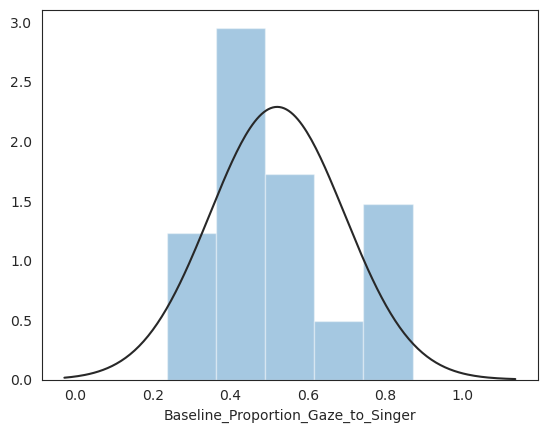

In [ ]:
# Set Seaborn theme for data visualisations.
sns.set_style("white");

# PLotting a histogram and Kernel density estimate of the baseline gaze proportion scores
sns.distplot(red_df["Baseline_Proportion_Gaze_to_Singer"], fit = stats.norm, kde= False);

Just Eyeballing the data visualistaiton above might suggest that the data is not normally distributed. However, there are only 32 data points, so we have a high level of uncertainty around determining this. As such the use of a normal likelihood may still be appropriate and as the intial authors used a one sample t-test, which assumes normal distributed data, the analysis below will assume a normal likelihood for the Bayesain equivalent of the one-sample t-test.

# Step 2 - Define the descriptive statistical model 

\begin{align*}
y_i &\sim Normal(\mu, \sigma) 
\\ \mu &\sim Normal(0.5, 0.2) 
\\ \sigma &\sim Exponential(0.1) 
\end{align*} 

<font size = "3">The formulation for presenting statistical models here follows that used by McElreath (2020) for its intuitive nature. In plain english the model specifies that the dependent variable $y_i$ is distributed normally in terms of the Likelihood. The $\mu$ and $\sigma$ parameters are to be estimated. With the priors for the $\mu$ parameter being $Normal(0.5, 0.2)$ and the $\sigma$ being expoentially distributed $Exponential(0.01)$


# Step 3 - Specifying priors

Following the description of the statistical model above the readers should rightly review and criticise the model freely, especialliy in asking why i selected these priors. The priors were selected using the prior predictive checks i ran in the code below to determine if my priors can generate data that falls reasonable on the dependent variable outcome space for the data generating process i am trying to model which in this case is expert rating of baseline gaze proportion scores of infants.

## Prior predictive checks

### Visualising priors

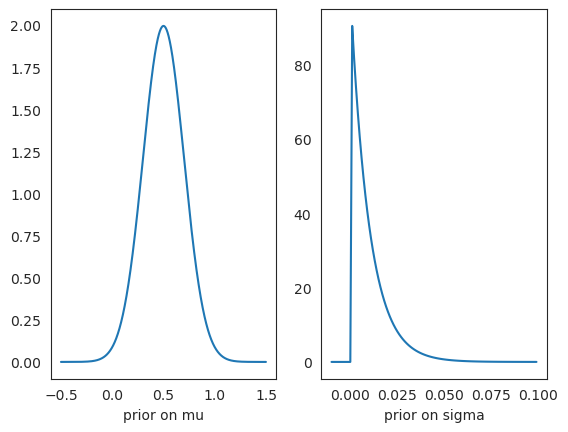

In [ ]:
# Visualise prior on mean parameter.
x = np.arange(-0.5, 1.5, 0.001)

plt.subplot(1, 2, 1)
plt.plot(x, stats.norm.pdf(x,loc=0.5, scale=0.2));
plt.xlabel("prior on mu");

# Visualise prior on Standard deviation parameter.
x = np.arange(-.01, .1, 0.001)
plt.subplot(1, 2, 2)
plt.plot(x, stats.expon.pdf(x, scale = 0.01));
plt.xlabel("prior on sigma");

### Simulating data based on priors

Following the visualisation of the priors for the parameters of the model to 
check how they interact it is important to run prior predcitive check by 
simulating data based on the model.

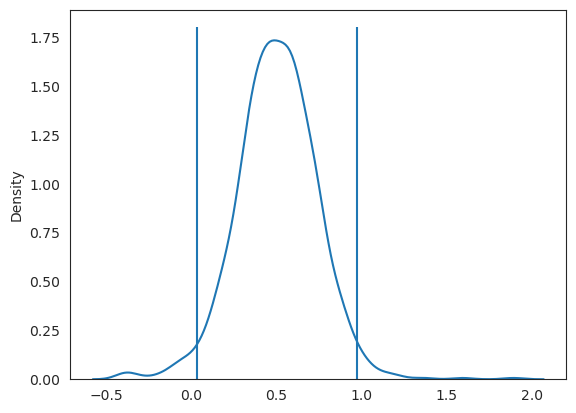

In [ ]:
# Set seed to allow for the reproduciblity of notebook.
np.random.seed(1)

# Set the number of data point to sample
n = 1000
#Specify prior values for mu
mu_loc = 0.5
mu_scale =.2

#Specify prior values for sigma
sd_scale = .1


# Simulate data from the priors for the mean and SD for the normal model specified above.
sample_mu = np.random.normal(loc= mu_loc, scale = mu_scale, size = n )
sample_sigma = np.random.exponential(scale = sd_scale, size = n )
prior_PC = np.random.normal(loc = sample_mu, scale = sample_sigma, size = n)

# Plot the simulated data
sns.kdeplot(prior_PC);

# Plot vertical line of the 2 standard deviatons either side of the simulated data.
plt.vlines((np.mean(prior_PC) + 2 * np.std(prior_PC)), ymin = 0, ymax = 1.8);
plt.vlines((np.mean(prior_PC) - 2 * np.std(prior_PC)), ymin = 0, ymax = 1.8);

The prior predictive check show that generate reasonable data for baseline child gaze rated by expert rates on a proprotion scale between 0 and 1 follwing a normal model. Rember it doesnt matter if it looks like the data this is all in reltion to prior so everything is done in terms of assumptions of the unobserved data generating process (which in this case we assume is can be described by a normal pdf) not the data we actually observed.

# Step 4 - Use Bayes rule
The software of choice to conduct Bayesian inference on the data here is Stan (Carpenter et al., 2017) and the model is specified below.

## Stan model of Bayesian One sample t-test

In [ ]:
# Generate python dictionary to pass to Stan model to sample and run Bayesian One sample.
data = {'N': len(red_df),
        'y':  red_df["Baseline_Proportion_Gaze_to_Singer"].values}

In [ ]:
model_path = "stan/one_sample__t_test.stan"
sm = CmdStanModel(stan_file = model_path, cpp_options={'STAN_THREADS': 'TRUE'},
                     force_compile = True)   

11:37:06 - cmdstanpy - INFO - compiling stan file /home/harrison/Desktop/githubrepos/Statistical-methods-for-research-workers-bayes-for-psychologists-and-neuroscientists/Chapter_2_-_One-sample_t-test/stan/one_sample__t_test.stan to exe file /home/harrison/Desktop/githubrepos/Statistical-methods-for-research-workers-bayes-for-psychologists-and-neuroscientists/Chapter_2_-_One-sample_t-test/stan/one_sample__t_test
11:37:19 - cmdstanpy - INFO - compiled model executable: /home/harrison/Desktop/githubrepos/Statistical-methods-for-research-workers-bayes-for-psychologists-and-neuroscientists/Chapter_2_-_One-sample_t-test/stan/one_sample__t_test


In [ ]:
write_stan_json("data.json", data = data)

# Fit the One_z_test_model specified above.
fit = sm.sample("data.json", chains = n_chains , iter_sampling=n_samples, iter_warmup = n_warmup, parallel_chains = n_chains, adapt_delta = stepS)

11:37:30 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

chain 5 |          | 00:00 Status

chain 6 |          | 00:00 Status

chain 7 |          | 00:00 Status

chain 8 |          | 00:00 Status

chain 9 |          | 00:00 Status

chain 10 |          | 00:00 Status

chain 11 |          | 00:00 Status

chain 12 |          | 00:00 Status

chain 13 |          | 00:00 Status

chain 14 |          | 00:00 Status

chain 15 |          | 00:00 Status

chain 16 |          | 00:00 Status

11:37:30 - cmdstanpy - INFO - CmdStan done processing.
11:37:30 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in 'one_sample__t_test.stan', line 27, column 0 to column 22)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in 'one_sample__t_test.stan', line 27, column 0 to column 22)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in 'one_sample__t_test.stan', line 27, column 0 to column 22)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in 'one_sample__t_test.stan', line 27, column 0 to column 22)
Consider re-running with show_console=True if the above output is unclear!


In [ ]:
# Convert to xarray object.
idata = az.from_cmdstanpy(
    posterior=fit,
    posterior_predictive=['yrep'],
    observed_data={'y': data['y']}  # Use a dictionary here
)

In [ ]:
# Using arviz generate summary table for parameters and generated quantities.
az.summary(idata, var_names = ['mu', 'sigma', 'diff', 'Cohen_D'])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
mu,0.521,0.032,0.461,0.583,0.000,0.000,11413.0,8675.0,1.0
sigma,0.184,0.024,0.140,0.229,0.000,0.000,11948.0,10610.0,1.0
diff,0.021,0.032,-0.039,0.083,0.000,0.000,11413.0,8675.0,1.0
Cohen_D,0.114,0.174,-0.206,0.458,0.002,0.001,11751.0,9574.0,1.0


# Post model fit-visualisations - Bayesian one sample Z-test

## Posterior distributions plots

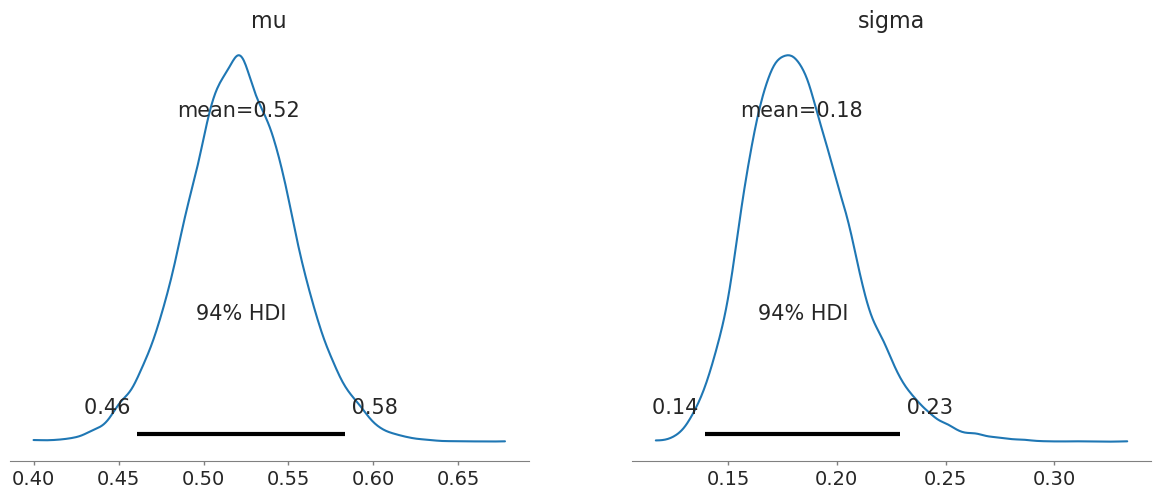

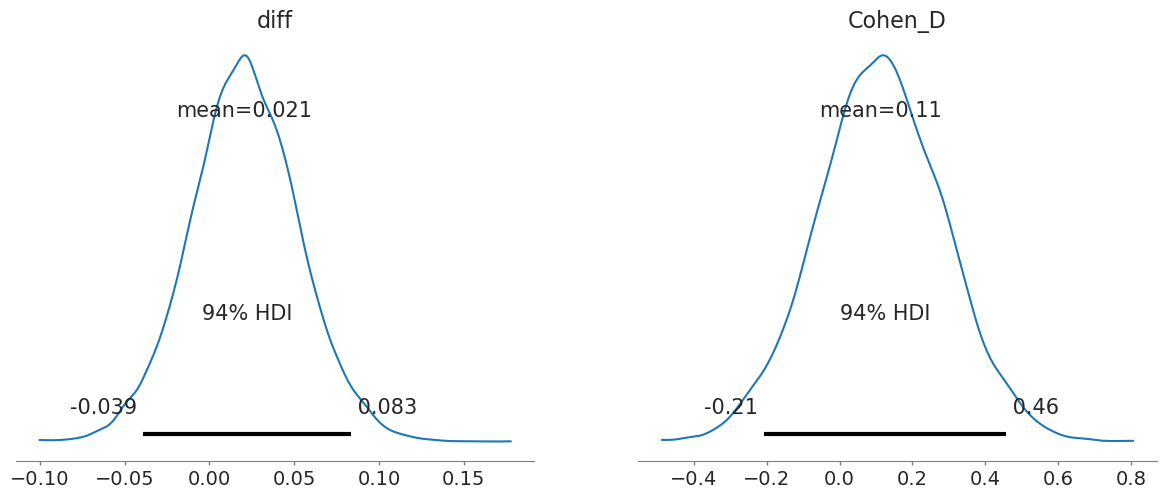

In [ ]:
# Using arviz built in Bayesian anlysis plot_posterior funcion to display the posterior probabilty distributions
# for the fitted model parameter estimates.
az.plot_posterior(idata, var_names = ["mu", "sigma"]);
az.plot_posterior(idata, var_names = ["diff", "Cohen_D"]);

## Autocorrelation plots

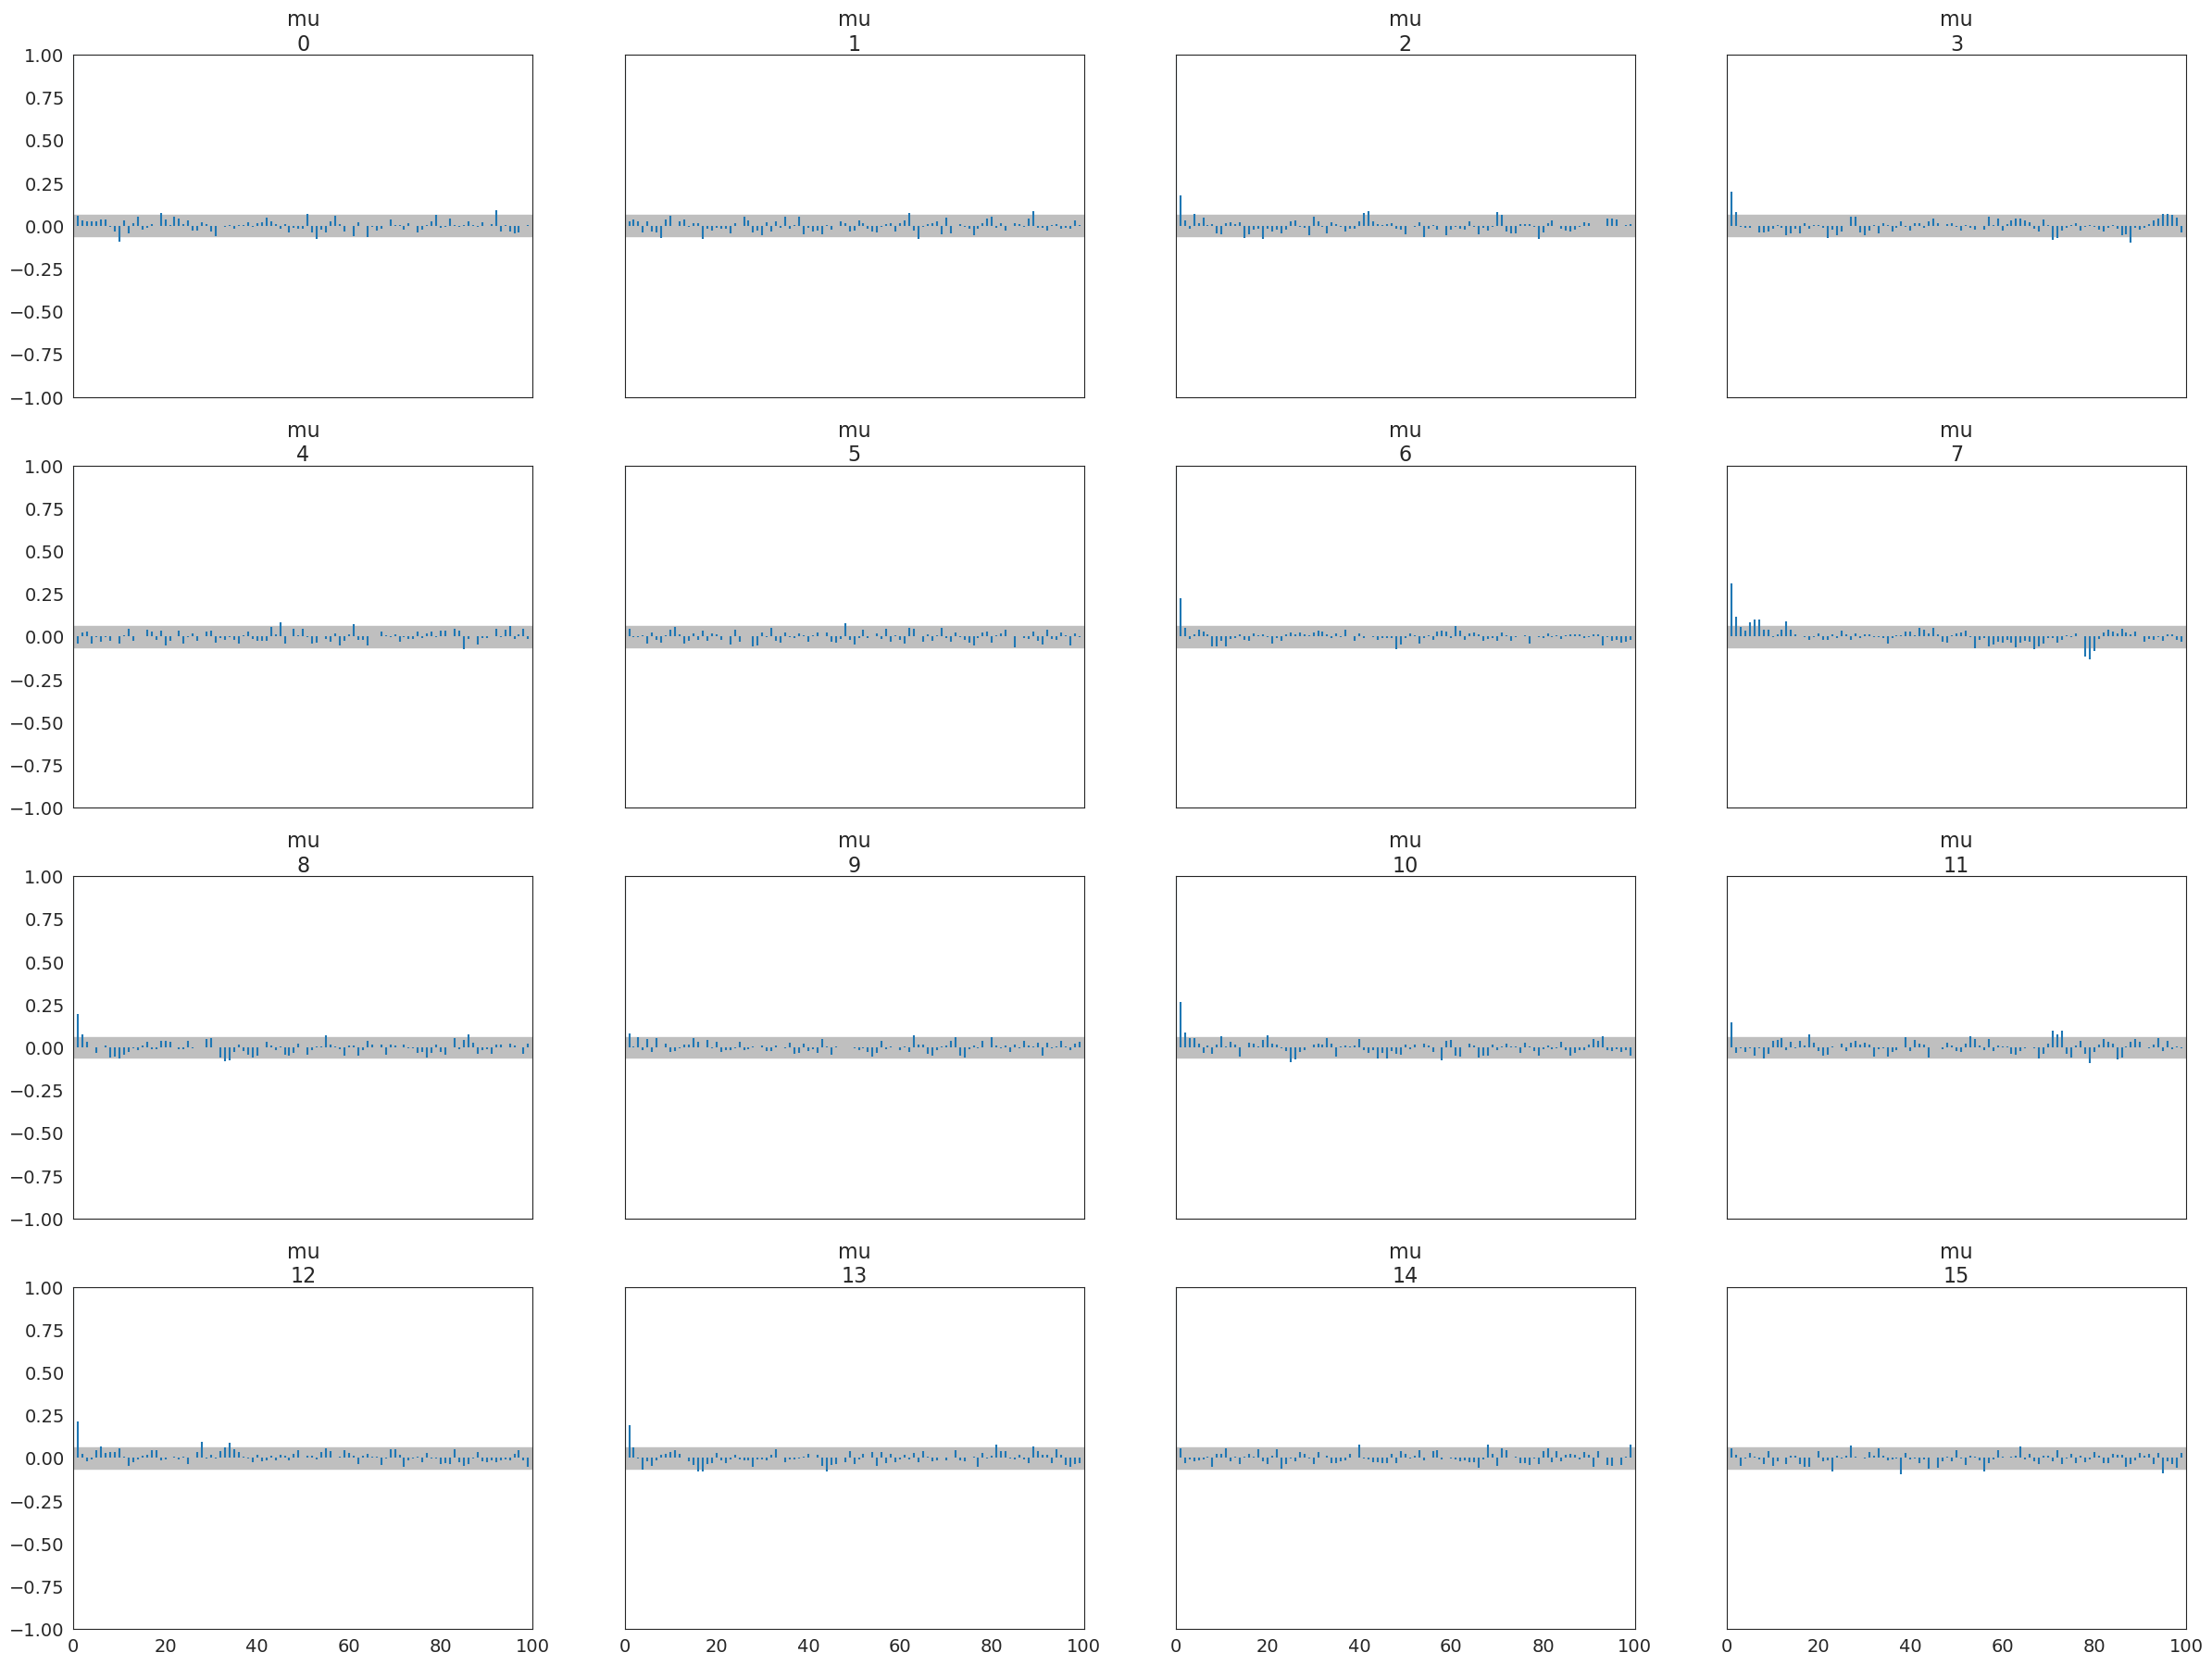

In [ ]:
# Using the arviz package the autocorrelation of the 4 MCMC chains can be plotted.
az.plot_autocorr(idata, var_names = ["mu"]);

The autocorrelation plots do not show any serious autocorrelation problems, as the values quickly decrease to 0.

## MCMC traceplots

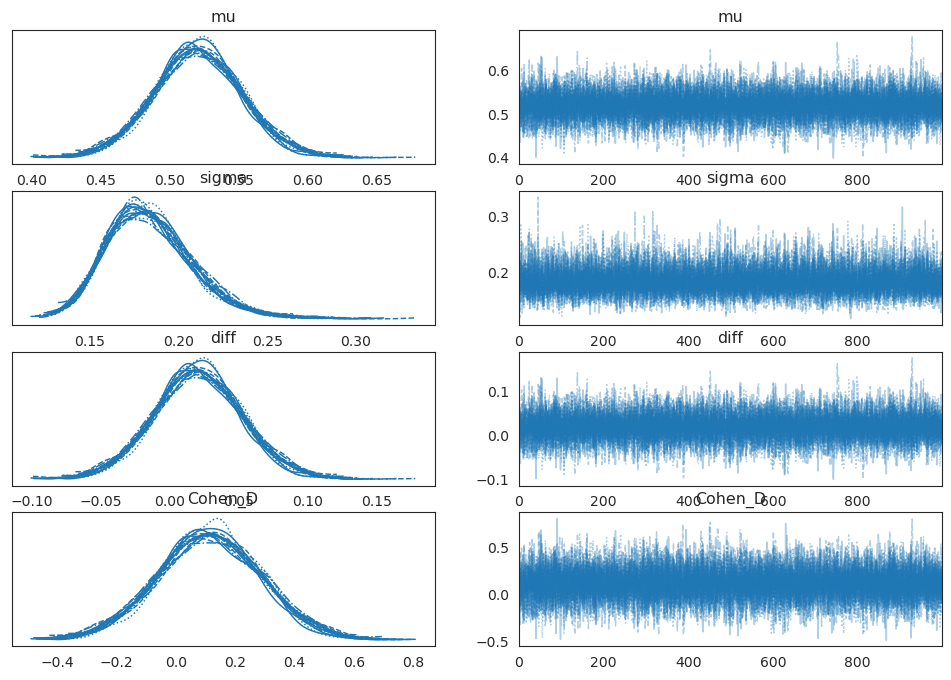

In [ ]:
az.plot_trace(idata, var_names=("mu", "sigma", "diff", "Cohen_D"));

The traceplot show good mixing of chains and show a hairy catepillar.

# Step 5 - Posterior predictive checks

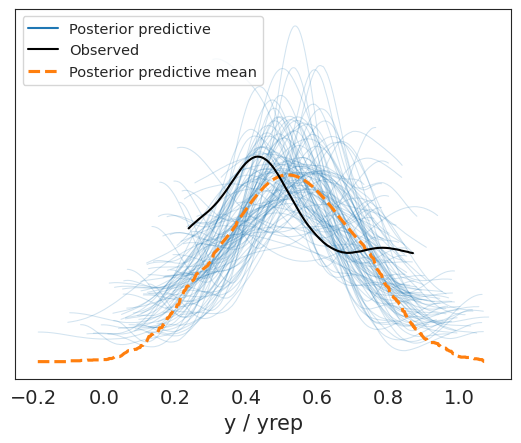

In [ ]:
# Plot posterior simulated data sets for posterior predictive check
az.plot_ppc(idata, data_pairs = {"y" : "yrep"}, num_pp_samples = 100);

The posterior predictive check shows that the simulated data sets condtioning the model on the data vary from  the original data sets. This could mean many things; the first being that an alternative better fitting model may need to be fit or   secondly that the small amount of data from a highly variable measure of infant gaze which has to go through a noisy expert rater) is presenting a simple reality that our model and its resulting inferences are more uncertain. Of course, this is not neccesarily a problem it just needs to be communicated to and appreciated by the audience that is viewing the results of the analysis, whom may even recommend improvements for the model and the modellers choices.

# Reporting the results of the Bayesian one sample t-test equivalent

<font size = "3">As Kruscke correctly points out there is not standard formula or presentation method for results like the APA guide for reporting frequentist analyses using the Bayesian framework. It is likely there never will be, because as McElreath (2020) explains, Bayesian data analysis is more like a engineering approach to the problem and the resulting model that is fit will be analysis specific. In addition, as Gabry et al, (2019) have argued visualisations maybe even more key, so all the visualtions above would have to be included with any write up. Anyway, the write up below generally follows the advice of Kruscke (2015) chapter 25. In any application though it comes down to the problem to be described and the audience that needs to be convinced. </p><br/>

<h2>Write up</h2><br/>

# References

Carpenter, B., Gelman, A., Hoffman, M. D., Lee, D., Goodrich, B., Betancourt, M., ... & Riddell, A. (2017). Stan: a probabilistic programming language. Grantee Submission, 76(1), 1-32.

Dienes, Z. (2014). Using Bayes to get the most out of non-significant results. Frontiers in psychology, 5, 781.

Gabry, J., Simpson, D., Vehtari, A., Betancourt, M., & Gelman, A. (2019). Visualization in Bayesian workflow. Journal of the Royal Statistical Society: Series A (Statistics in Society), 182(2), 389-402.
    
Kruschke, J. (2015). Doing Bayesian data analysis: A tutorial with R, JAGS and Stan. Oxford, England: Academic Press.    
    
McElreath, R. (2020). Statistical rethinking: A Bayesian course with examples in R and Stan.Boca Raton: CRC Press.

Mehr, S. A., Song. L. A., & Spelke, E. S. (2016). For 5-month-old infants, melodies are social. Psychological Science, 27, 486-501.